# Importing Libaries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime               import datetime, timedelta

# Libraries for model building
from scipy.stats.mstats     import winsorize
from sklearn.linear_model   import LogisticRegression 
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.svm            import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics        import auc
from sklearn.metrics        import roc_auc_score

# Importing data

In [37]:
# Importing data

camp = pd.read_csv('../data/raw/campaigns.csv', sep=';')
donors = pd.read_csv('../data/raw/donors.csv', sep=',')
gifts = pd.read_csv('../data/raw/gifts.csv', sep=',')
sc6 = pd.read_csv('../data/raw/selection campaign 6169.csv')
sc7 = pd.read_csv('../data/raw/selection campaign 7244.csv')

In [38]:
# Basic exploration 
print("Donors shape:", donors.shape) 
print("Gifts shape:", gifts.shape) 
print("Campaign 6169 shape:", sc6.shape) 
print("Campaign 7244 shape:", sc7.shape)

Donors shape: (44691, 7)
Gifts shape: (216594, 4)
Campaign 6169 shape: (34888, 1)
Campaign 7244 shape: (25645, 1)


# References

In [39]:
rd1 = pd.to_datetime('2018-09-04') # date of 6169 campaign
rd2 = pd.to_datetime('2019-06-18') # date of 7244 campaign

# I/ Data description + Cleaning

## 1) Campaign

### General inspection

In [40]:
# Displaying the campaign table
camp.head()

,campaignID,date,lettersSent,CostUnit
0,153,13/12/2004,6 873,"0,17 €"
1,154,01/01/2005,7 656,"0,30 €"
2,180,18/01/2005,9 933,"0,20 €"
3,433,29/01/2005,7 448,"0,59 €"
4,476,12/02/2005,6 605,"0,51 €"


In [41]:
# Displaying information
camp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   campaignID   367 non-null    int64 
 1   date         367 non-null    object
 2   lettersSent  367 non-null    object
 3   CostUnit     367 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.6+ KB


### Missing values and outliers

In [42]:
# Convert date to datetime
camp['date'] = pd.to_datetime(camp['date'])

C:\Users\Source\AppData\Local\Temp\ipykernel_17656\4099330542.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  camp['date'] = pd.to_datetime(camp['date'])


In [43]:
camp.head()

,campaignID,date,lettersSent,CostUnit
0,153,2004-12-13,6 873,"0,17 €"
1,154,2005-01-01,7 656,"0,30 €"
2,180,2005-01-18,9 933,"0,20 €"
3,433,2005-01-29,7 448,"0,59 €"
4,476,2005-02-12,6 605,"0,51 €"


In [44]:
# Convert the letterSent and cost per unit to a number
# To find outliers, we need to convert columns to integer before
camp['lettersSent'] = (
    camp['lettersSent']
        .astype(str)
        .str.replace(r'\D+', '', regex=True)
        .astype(int)
)

camp['CostUnit'] = (
    camp['CostUnit']
        .astype(str)
        .str.replace(r'[^0-9,.-]', '', regex=True)
        .str.replace(',', '.', regex=False)
        .astype(float)
)
camp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   campaignID   367 non-null    int64         
 1   date         367 non-null    datetime64[ns]
 2   lettersSent  367 non-null    int64         
 3   CostUnit     367 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 11.6 KB


In [45]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(camp.isna().sum())
print('---------------------------------')
print(f'The data shows {camp.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
campaignID     0
date           0
lettersSent    0
CostUnit       0
dtype: int64
---------------------------------
The data shows 0 missing values


In [46]:
# Finding outliers (using only the numerical columns)
num_cols = camp.select_dtypes(include=['float', 'int']).columns.drop('campaignID')
# We define our boundaries
lower = camp[num_cols].quantile(0.01)
upper = camp[num_cols].quantile(0.99)

# printing the results
print('Lower bounds:\n',lower)
print('-------------------------')
print('Upper bounds:\n', upper)

Lower bounds:
 lettersSent    5243.66
CostUnit          0.02
Name: 0.01, dtype: float64
-------------------------
Upper bounds:
 lettersSent    47746.96
CostUnit           0.61
Name: 0.99, dtype: float64


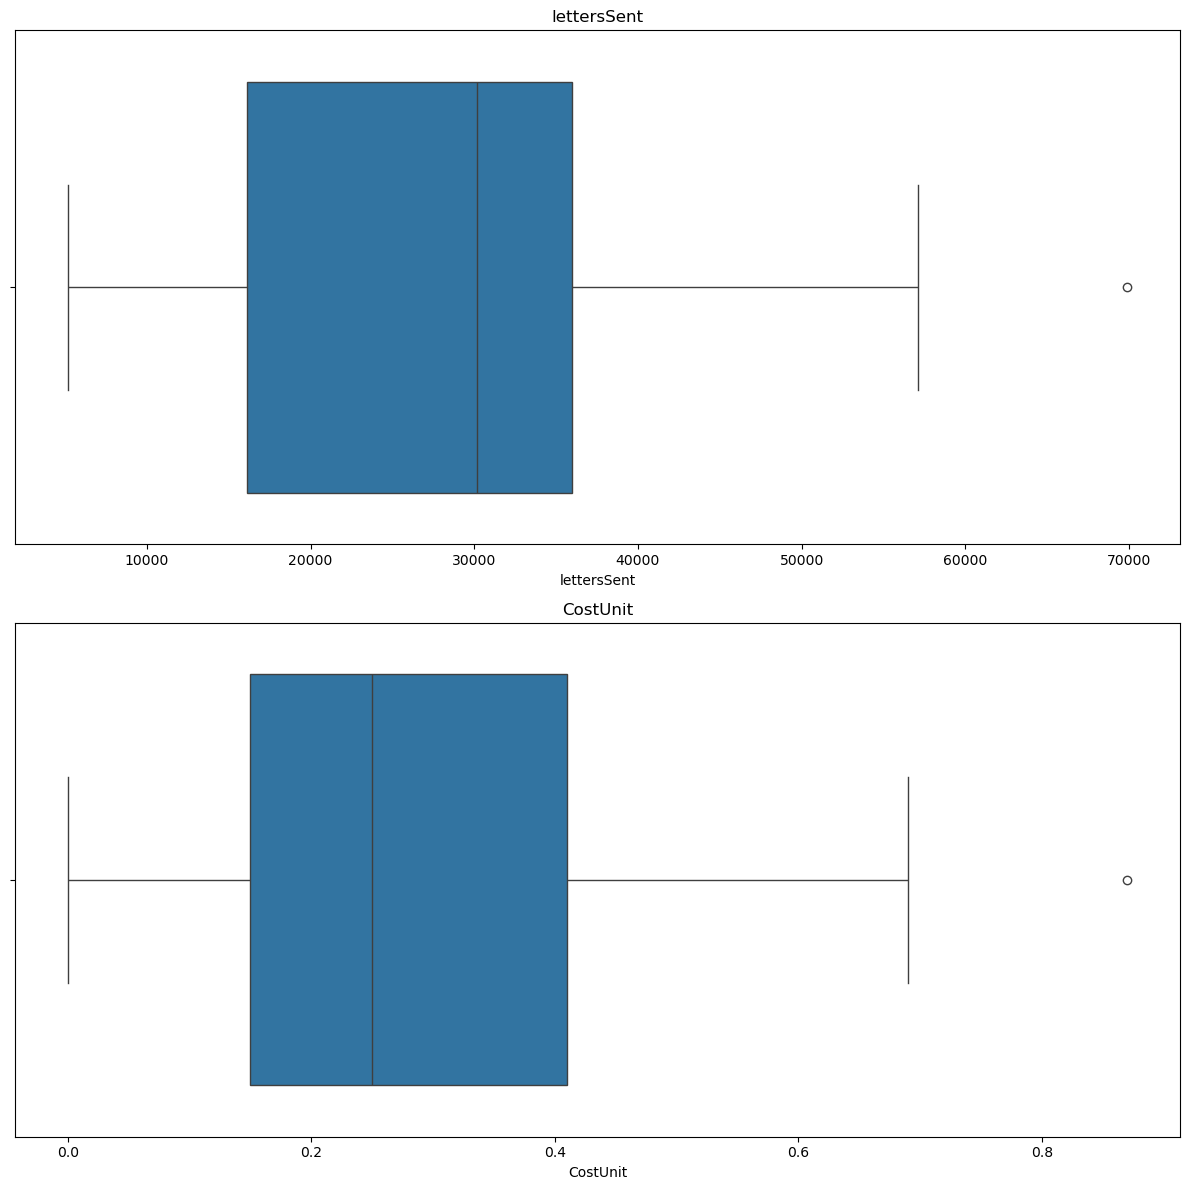

In [47]:
# Verifying outliers
# We use boxplots to identify potential outliers

fig, ax = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(12, 12))

for i, col in enumerate(num_cols):
    sns.boxplot(ax=ax[i], x=camp[col])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [48]:
# Replace lower and upper values by the value of bottom 1% and top 99% (winsorization)
camp = camp.copy()
camp[num_cols] = camp[num_cols].clip(lower=lower, upper=upper, axis=1)

In [49]:
# Verifying winsorization worked
for col in num_cols:
    print(col, 'min :', round(camp[col].min(),2))
    print(col, 'max :', round(camp[col].max(),2))

lettersSent min : 5243.66
lettersSent max : 47746.96
CostUnit min : 0.02
CostUnit max : 0.61


In [50]:
camp.head(2)

,campaignID,date,lettersSent,CostUnit
0,153,2004-12-13,6873.0,0.17
1,154,2005-01-01,7656.0,0.30


## 2) Donors

### General inspection

In [51]:
# Displaying the donors table
donors.head()

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,D100001,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967
1,D100002,2260.0,Antwerp,Flanders,M,NL,01/14/1952
2,D100003,1780.0,Flemish Brabant,Flanders,M,NL,12/23/1986
3,D100004,1020.0,Brussels,Brussels,F,FR,03/29/1952
4,D100005,1020.0,Brussels,Brussels,F,FR,06/25/1986


In [52]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   donorID      44691 non-null  object 
 1   zipcode      44689 non-null  float64
 2   province     44691 non-null  object 
 3   region       44691 non-null  object 
 4   gender       44659 non-null  object 
 5   language     44691 non-null  object 
 6   dateOfBirth  44691 non-null  object 
dtypes: float64(1), object(6)
memory usage: 2.4+ MB


### Missing values and outliers

In [53]:
# Convert date to datetime
donors['dateOfBirth'] = pd.to_datetime(donors['dateOfBirth'])

In [54]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(donors.isna().sum())
print('---------------------------------')
print(f'The data shows {donors.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID         0
zipcode         2
province        0
region          0
gender         32
language        0
dateOfBirth     0
dtype: int64
---------------------------------
The data shows 34 missing values


In [55]:
donors.gender.mode()

0    M
Name: gender, dtype: object

In [56]:
# Handling missing values

# zipcode
donors = donors.dropna(subset=['zipcode']) # since it represents only two observation and there is no other logical way to inpute them

# gender
gender_mode = donors['gender'].mode()[0]
donors['gender'] = donors['gender'].fillna(value=gender_mode) #filling by the mode seems relevant for this amount of data (32 out of 44 689 clients)

print(f'The data shows {donors.isna().sum().sum()} missing values now')

The data shows 0 missing values now


In [57]:
# Checking that there are indeed 44 689 different clients
donors.shape

(44689, 7)

In [58]:
donors.zipcode

0        1861.0
1        2260.0
2        1780.0
3        1020.0
4        1020.0
          ...  
44686    4900.0
44687    3600.0
44688    3061.0
44689    1950.0
44690    1160.0
Name: zipcode, Length: 44689, dtype: float64

In [59]:
# Zipcode was imported as float (e.g., 1180.0), but zipcodes are categorical labels
# We convert to integer to remove decimals, then to string so models don't treat it as numeric (which can mislead models)
donors['zipcode'] = donors['zipcode'].astype('Int64').astype(str)

In [60]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44689 entries, 0 to 44690
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   donorID      44689 non-null  object        
 1   zipcode      44689 non-null  object        
 2   province     44689 non-null  object        
 3   region       44689 non-null  object        
 4   gender       44689 non-null  object        
 5   language     44689 non-null  object        
 6   dateOfBirth  44689 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 2.7+ MB


In [61]:
donors.head(2)

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14


## 3) Gifts

### General inspection

In [62]:
# Displaying the gifts table
gifts.head()

,donorID,campaignID,amount,date
0,D100001,NaN,"12,39",23/03/2004
1,D100001,1577.0,"12,39",11/10/2007
2,D100001,1634.0,"6,69",28/12/2007
3,D100001,1778.0,"24,79",14/06/2008
4,D100001,1808.0,"7,44",09/07/2008


In [63]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216594 entries, 0 to 216593
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   donorID     216594 non-null  object 
 1   campaignID  200957 non-null  float64
 2   amount      216594 non-null  object 
 3   date        216594 non-null  object 
dtypes: float64(1), object(3)
memory usage: 6.6+ MB


### Missing values and outliers

In [64]:
# Convert date to datetime
gifts['date'] = pd.to_datetime(gifts['date'])

# Be more specific
gifts = gifts.rename(columns={'date' : 'gift_date'})

C:\Users\Source\AppData\Local\Temp\ipykernel_17656\2177558126.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  gifts['date'] = pd.to_datetime(gifts['date'])


In [65]:
# Convert amount to numeric
gifts['amount'] = (
    gifts['amount']
    .astype(str)
    .str.replace(".", "", regex=False)   # remove thousand separators
    .str.replace(",", ".", regex=False)  # convert decimal comma → dot
)
gifts['amount'] = pd.to_numeric(gifts['amount'], errors='coerce')



In [66]:
gifts

,donorID,campaignID,amount,gift_date
0,D100001,NaN,12.39,2004-03-23
1,D100001,1577.0,12.39,2007-10-11
2,D100001,1634.0,6.69,2007-12-28
3,D100001,1778.0,24.79,2008-06-14
4,D100001,1808.0,7.44,2008-07-09
...,...,...,...,...
216589,D265584,6169.0,300.00,2018-09-23
216590,D281770,6169.0,30.00,2018-09-08
216591,D317880,6169.0,157.50,2018-09-12
216592,D480980,6169.0,36.00,2018-09-12


In [67]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(gifts.isna().sum())
print('---------------------------------')
print(f'The data shows {gifts.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID           0
campaignID    15637
amount           23
gift_date         0
dtype: int64
---------------------------------
The data shows 15660 missing values


Handling the missing ID's : 
- A missing ID means that a donation was NOT part of any campaign - it was a spontaneous donation
- This gives a valuable information and could be very useful for our models 
- Thus, we should keep them as they are 

In [68]:
gifts.head()

,donorID,campaignID,amount,gift_date
0,D100001,NaN,12.39,2004-03-23
1,D100001,1577.0,12.39,2007-10-11
2,D100001,1634.0,6.69,2007-12-28
3,D100001,1778.0,24.79,2008-06-14
4,D100001,1808.0,7.44,2008-07-09


In [69]:
gifts['amount'].describe()

count    2.165710e+05
mean     5.751130e+01
std      1.011234e+04
min      1.000000e-01
25%      1.000000e+01
50%      2.479000e+01
75%      3.200000e+01
max      4.000000e+06
Name: amount, dtype: float64

In [72]:
gifts_raw = pd.read_csv("../data/raw/gifts.csv", dtype=str)

In [73]:
gifts_raw.sort_values(by = 'amount', ascending=False).head()

,donorID,campaignID,amount,date
53964,D106049,1778,"991,57",31/05/2008
92389,D111467,NaN,"991,57",31/05/2003
129272,D118321,1962,"991,57",01/01/2009
75388,D109008,1185,"99,16",03/09/2006
92378,D111466,1556,"99,16",09/09/2007


In [74]:
gifts.sort_values(by = 'amount', ascending=False).head()

,donorID,campaignID,amount,gift_date
153012,D123168,NaN,4000000.00,2010-04-26
141895,D120861,1917.0,2479000.00,2008-11-17
150654,D122679,2417.0,30000.00,2010-07-04
182959,D130966,1377.0,12394.68,2007-04-21
21410,D102552,3785.0,5000.00,2014-05-03


In [75]:
gifts[gifts['donorID'] == 'D123168']

,donorID,campaignID,amount,gift_date
153012,D123168,NaN,4000000.0,2010-04-26
153013,D123168,2417.0,30.0,2010-07-09


In [76]:
gifts_raw[gifts_raw['donorID'] == 'D123168']

,donorID,campaignID,amount,date
153012,D123168,NaN,"4000000,0",26/04/2010
153013,D123168,2417,"30,0",09/07/2010


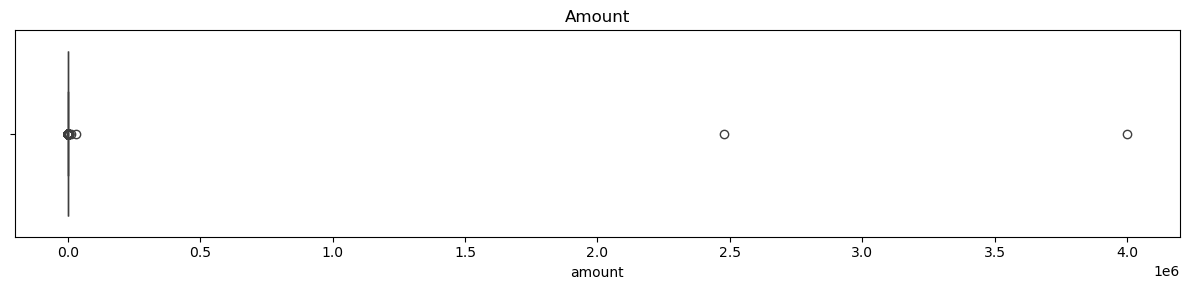

In [77]:
# Verifying outliers

fig, ax = plt.subplots(figsize=(12, 3))

sns.boxplot(x=gifts['amount'])
ax.set_title('Amount')

plt.tight_layout()
plt.show()

In [79]:
# Winsorizing the results
lower = gifts['amount'].quantile(0.01)
upper = gifts['amount'].quantile(0.99)

# printing the results
print(lower)
print(upper)

2.48
123.95


In [81]:
# Replace lower and upper values by the value of bottom 1% and top 99% (winsorization)
gifts = gifts.copy()
gifts['amount'] = gifts['amount'].clip(lower=lower, upper=upper)

In [83]:
gifts.head(2)

,donorID,campaignID,amount,gift_date
0,D100001,NaN,12.39,2004-03-23
1,D100001,1577.0,12.39,2007-10-11


In [84]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216594 entries, 0 to 216593
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   donorID     216594 non-null  object        
 1   campaignID  200957 non-null  float64       
 2   amount      216571 non-null  float64       
 3   gift_date   216594 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 6.6+ MB


## 4) Selection campaign 6169

### General inspection

In [85]:
# Displaying the sc6 table
sc6.head()

,donorID
0,D100001
1,D100002
2,D100004
3,D100008
4,D100009


### Missing values

In [86]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(sc6.isna().sum())
print('---------------------------------')
print(f'The data shows {sc6.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID    0
dtype: int64
---------------------------------
The data shows 0 missing values


## 5) selection campaign 7244

### General inspection

In [87]:
# Displaying the sc7 table
sc7.head()

,donorID
0,D100001
1,D100002
2,D100008
3,D100009
4,D100010


### Missing values

In [88]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(sc7.isna().sum())
print('---------------------------------')
print(f'The data shows {sc7.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID    0
dtype: int64
---------------------------------
The data shows 0 missing values


# II/ Dependent variables (train + validation set)

## 1) Train set

In [3564]:
# Setting up the campaign date
campaign_date = rd1

In [3565]:
# Merging gifts and sc6 because gifts contains the donation history of the donors and we want to select those who were selected in the campaign
# We use a left join because we want all the donors from the campaign, even if they never donated to be able to understand why some gave and 
# other did not based on a set of feature engineering that will come afterwards
donors_sc6 = sc6.merge(gifts, on='donorID', how='left')
donors_sc6.head(2)

,donorID,campaignID,amount,gift_date
0,D100001,1577.0,1239.0,2007-10-11
1,D100001,1634.0,669.0,2007-12-28


In [3566]:
# We want to know which donors donated after the campaign 30 euros or more
# We also want the variable to be at the donor level, not the gift one
# Using .unique() is a way to achieve such a granularity
target_donors = gifts[(gifts['campaignID'] == 6169) & (gifts['amount'] >= 30)]['donorID'].unique()

In [3567]:
# We must filter by campaignID because the sc6 file is in reality only a mailing list
# Therefore every people in the list only received a letter
# Even if a person is in the list and donated after the campaign does not necessarily mean that the gift was made due to campaign 6169
# For example, if the person gave to a different campaignID, we cannot explicitely say that she gave because of the campaign 6169
# On the contrary, if we target only the persons that directly answered to the campaign, the quality of the target variable shall be increased

In [3568]:
# Setting up the target variable for the train set
basetable_train = sc6.copy()

basetable_train['target'] = 0

basetable_train.loc[basetable_train['donorID'].isin(target_donors), 'target'] = 1
basetable_train.head()

,donorID,target
0,D100001,0
1,D100002,0
2,D100004,0
3,D100008,0
4,D100009,0


In [3569]:
basetable_train['target'].value_counts()

target
0    33697
1     1191
Name: count, dtype: int64

In [3570]:
basetable_train.head()

,donorID,target
0,D100001,0
1,D100002,0
2,D100004,0
3,D100008,0
4,D100009,0


## 2) Validation set

In [3571]:
# Following the exact same steps and logic

In [3572]:
campaign_date = rd2

In [3573]:
donors_sc7 = sc7.merge(gifts, on='donorID', how='left')
donors_sc7.head(2)

,donorID,campaignID,amount,gift_date
0,D100001,1577.0,1239.0,2007-10-11
1,D100001,1634.0,669.0,2007-12-28


In [3574]:
target_donors = gifts[(gifts['campaignID'] == 7244) & (gifts['amount'] >= 30)]['donorID'].unique()

In [3575]:
# Setting up the target variable for the train set
basetable_val = sc7.copy()

basetable_val['target'] = 0

basetable_val.loc[basetable_val['donorID'].isin(target_donors), 'target'] = 1
basetable_val.head()

,donorID,target
0,D100001,0
1,D100002,0
2,D100008,0
3,D100009,0
4,D100010,0


In [3576]:
basetable_val['target'].value_counts()

target
0    25645
Name: count, dtype: int64

In [3577]:
basetable_val.head()

,donorID,target
0,D100001,0
1,D100002,0
2,D100008,0
3,D100009,0
4,D100010,0


# III/ Independent variable + basetable creation

## 1) basetable_train

In [3578]:
# Basetable creation
basetable_train = pd.merge(basetable_train, donors, on='donorID', how='left')
# we start with the donors table since it presents a lot of information
basetable_train.head(2)

,donorID,target,zipcode,province,region,gender,language,dateOfBirth
0,D100001,0,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24
1,D100002,0,2260.0,Antwerp,Flanders,M,NL,1952-01-14


### a) demographic

#### age

In [3579]:
# Computing the age
basetable_train['age'] = (rd1.year - pd.to_datetime(basetable_train['dateOfBirth'], errors='coerce').dt.year).astype('Int64')

#### age_group

In [3580]:
# Computing the age group

def age_group(age):
    if age <= 14:
        return 1
    elif age <= 24:
        return 2
    elif age <= 64:
        return 3
    else:
        return 4

basetable_train['age_group'] = basetable_train['age'].apply(age_group)

#### regions

In [3581]:
# Get dummies from the regions
dummies = pd.get_dummies(basetable_train['region'], prefix='region', dtype=int, drop_first=True)
basetable_train = pd.concat([basetable_train, dummies], axis=1)
basetable_train = basetable_train.drop(columns=['region'])

#### province

In [3582]:
# Get dummies from the province
dummies = pd.get_dummies(basetable_train['province'], prefix='province', dtype=int, drop_first=True)
basetable_train = pd.concat([basetable_train, dummies], axis=1)
basetable_train = basetable_train.drop(columns=['province'])
basetable_train.head()

,donorID,target,zipcode,gender,language,dateOfBirth,age,age_group,region_Flanders,region_Wallonia,...,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,province_Luxembourg,province_Namur,province_Walloon Brabant,province_West Flanders
0,D100001,0,1861.0,F,NL,1967-12-24,51,3,1,0,...,0,0,1,0,0,0,0,0,0,0
1,D100002,0,2260.0,M,NL,1952-01-14,66,4,1,0,...,0,0,0,0,0,0,0,0,0,0
2,D100004,0,1020.0,F,FR,1952-03-29,66,4,0,0,...,1,0,0,0,0,0,0,0,0,0
3,D100008,0,1780.0,M,FR,1937-08-30,81,4,1,0,...,0,0,1,0,0,0,0,0,0,0
4,D100009,0,1020.0,M,FR,1932-01-20,86,4,0,0,...,1,0,0,0,0,0,0,0,0,0


#### gender and language dummies

In [3583]:
# Get dummies for both gender and language because the algorithms do not support string

In [3584]:
dummies_gender = pd.get_dummies(basetable_train['gender'], prefix='gender', dtype=int, drop_first=True)
basetable_train = pd.concat([basetable_train, dummies_gender], axis=1)
basetable_train.drop(columns=['gender'], inplace=True)

In [3585]:
dummies_lang = pd.get_dummies(basetable_train['language'], prefix='lang', dtype=int, drop_first=True)
basetable_train = pd.concat([basetable_train, dummies_lang], axis=1)
basetable_train.drop(columns=['language'], inplace=True)

### b) timing (RFM + LOR)

In [3586]:
# Get past gift behavior
past_gifts = gifts.copy()
campaign_date = rd1
past_gifts_6169 = past_gifts[past_gifts['gift_date'] < campaign_date].copy()

In [3587]:
# Aggregate features by donorID
timing_6169 = past_gifts_6169.groupby('donorID').agg({
    'gift_date': ['max', 'min'],  # To calculate Recency and Length of Relationship
    'amount': ['count', 'sum', 'mean', 'max', 'min'] # Frequency and Monetary
})

# Adding a suffix
timing_6169.columns = ['_'.join(col).strip() for col in timing_6169.columns.values]
timing_6169.reset_index(inplace=True)

# Calculating Recency (Days since last gift to campaign date)
timing_6169['recency'] = (rd1 - timing_6169['gift_date_max']).dt.days

# Renaming columns for clarity
timing_6169.rename(columns={
    'amount_count': 'frequency',
    'amount_sum': 'total_amount',
    'amount_mean': 'avg_amount',
    'amount_max': 'max_amount'
}, inplace=True)

timing_6169.head(2)

,donorID,gift_date_max,gift_date_min,frequency,total_amount,avg_amount,max_amount,amount_min,recency
0,D100001,2011-12-30,2007-10-11,11,8510,773.636364,2479,100,2440
1,D100002,2015-01-10,2015-01-10,1,200,200.000000,200,200,1333


In [3588]:
# Adding the length of relationship (LOR)
timing_6169['LOR'] = timing_6169['gift_date_max'] - timing_6169['gift_date_min']

In [3589]:
# Merging within the basetable
basetable_train = pd.merge(basetable_train, timing_6169, on='donorID', how='left')

In [3590]:
basetable_train.head(3)

,donorID,target,zipcode,dateOfBirth,age,age_group,region_Flanders,region_Wallonia,province_Antwerp,province_Brussels,...,lang_NL,gift_date_max,gift_date_min,frequency,total_amount,avg_amount,max_amount,amount_min,recency,LOR
0,D100001,0,1861.0,1967-12-24,51,3,1,0,0,0,...,1,2011-12-30,2007-10-11,11.0,8510.0,773.636364,2479.0,100.0,2440.0,1541 days
1,D100002,0,2260.0,1952-01-14,66,4,1,0,1,0,...,1,2015-01-10,2015-01-10,1.0,200.0,200.000000,200.0,200.0,1333.0,0 days
2,D100004,0,1020.0,1952-03-29,66,4,0,0,0,1,...,0,2011-06-03,2005-07-02,25.0,44843.0,1793.720000,4958.0,300.0,2650.0,2162 days


### c) campaign-specific

In [3591]:
# We need this to get 'CostUnit' associated with each gift, therefore, we will temporarily merge gifts and campaign data to get it
# Indeed, gift is the only table that can link our basetable with campaign, since it has the campaignID key
gifts_with_costs = pd.merge(gifts, camp, on='campaignID', how='left')

In [3592]:
# Looking at behavior before the campaign we are predicting
history_campaigns = gifts_with_costs[gifts_with_costs['gift_date'] < rd1]

In [3593]:
# Get a donor-level granularity
campaign_features = history_campaigns.groupby('donorID').agg({
    'CostUnit': ['mean', 'min', 'max'],  # How expensive are the campaigns they support? (get an idea of their relative importance)
    'lettersSent': ['mean']   # What is the importance of the campaign they support
})

In [3594]:
# To get more consistent column names
campaign_features.columns = ['_'.join(col).strip() for col in campaign_features.columns.values]
campaign_features.reset_index(inplace=True)

In [3595]:
# Adding the cost per unit range
campaign_features['cost_range'] = campaign_features['CostUnit_max'] - campaign_features['CostUnit_min']
campaign_features.head()

,donorID,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,cost_range
0,D100001,0.335455,0.20,0.61,32877.454545,0.41
1,D100002,0.500000,0.50,0.50,37833.000000,0.00
2,D100003,0.196000,0.07,0.30,35984.792000,0.23
3,D100004,0.317200,0.08,0.61,34755.360000,0.53
4,D100005,0.312500,0.20,0.50,35195.750000,0.30


In [3596]:
# Merging with camp database to add some campaign-level information
basetable_train = pd.merge(basetable_train, campaign_features, on='donorID', how='left')

In [3597]:
# Adding some features
# 1) Average donation per letter received
basetable_train['amount_per_letter'] = basetable_train['total_amount'] / (basetable_train['lettersSent_mean'] + 1)

# 2) Donation Frequency relative to relationship length
basetable_train['gifts_per_year'] = basetable_train['frequency'] / (basetable_train['LOR'].dt.days / 365 + 1)

# 3) Ratio of recent vs average donation
basetable_train['current_value_ratio'] = basetable_train['max_amount'] / (basetable_train['avg_amount'] + 1)

In [3598]:
basetable_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   donorID                   34888 non-null  object         
 1   target                    34888 non-null  int64          
 2   zipcode                   34872 non-null  float64        
 3   dateOfBirth               34872 non-null  datetime64[ns] 
 4   age                       34872 non-null  Int64          
 5   age_group                 34888 non-null  int64          
 6   region_Flanders           34888 non-null  int64          
 7   region_Wallonia           34888 non-null  int64          
 8   province_Antwerp          34888 non-null  int64          
 9   province_Brussels         34888 non-null  int64          
 10  province_East Flanders    34888 non-null  int64          
 11  province_Flemish Brabant  34888 non-null  int64          
 12  prov

## 2) basetable_val

In [3599]:
# Basetable creation
basetable_val = pd.merge(basetable_val, donors, on='donorID', how='left')
# we start with the donors table since it presents a lot of information
basetable_val.head(2)

,donorID,target,zipcode,province,region,gender,language,dateOfBirth
0,D100001,0,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24
1,D100002,0,2260.0,Antwerp,Flanders,M,NL,1952-01-14


### a) demographic

#### age

In [3600]:
# Computing the age
basetable_val['age'] = (rd1.year - pd.to_datetime(basetable_val['dateOfBirth'], errors='coerce').dt.year).astype('Int64')

#### age_group

In [3601]:
# Computing the age group

def age_group(age):
    if age <= 14:
        return 1
    elif age <= 24:
        return 2
    elif age <= 64:
        return 3
    else:
        return 4

basetable_val['age_group'] = basetable_val['age'].apply(age_group)

#### region

In [3602]:
# Get dummies from the regions
dummies = pd.get_dummies(basetable_val['region'], prefix='region', dtype=int, drop_first=True)
basetable_val = pd.concat([basetable_val, dummies], axis=1)
basetable_val = basetable_val.drop(columns=['region'])

#### province

In [3603]:
# Get dummies from the province
dummies = pd.get_dummies(basetable_val['province'], prefix='province', dtype=int, drop_first=True)
basetable_val = pd.concat([basetable_val, dummies], axis=1)
basetable_val = basetable_val.drop(columns=['province'])
basetable_val.head()

,donorID,target,zipcode,gender,language,dateOfBirth,age,age_group,region_Flanders,region_Wallonia,...,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,province_Luxembourg,province_Namur,province_Walloon Brabant,province_West Flanders
0,D100001,0,1861.0,F,NL,1967-12-24,51,3,1,0,...,0,0,1,0,0,0,0,0,0,0
1,D100002,0,2260.0,M,NL,1952-01-14,66,4,1,0,...,0,0,0,0,0,0,0,0,0,0
2,D100008,0,1780.0,M,FR,1937-08-30,81,4,1,0,...,0,0,1,0,0,0,0,0,0,0
3,D100009,0,1020.0,M,FR,1932-01-20,86,4,0,0,...,1,0,0,0,0,0,0,0,0,0
4,D100010,0,1020.0,M,FR,1983-05-30,35,3,0,0,...,1,0,0,0,0,0,0,0,0,0


#### gender and language

In [3604]:
dummies_gender = pd.get_dummies(basetable_val['gender'], prefix='gender', dtype=int, drop_first=True)
basetable_val = pd.concat([basetable_val, dummies_gender], axis=1)
basetable_val.drop(columns=['gender'], inplace=True)

In [3605]:
dummies_lang = pd.get_dummies(basetable_val['language'], prefix='lang', dtype=int, drop_first=True)
basetable_val = pd.concat([basetable_val, dummies_lang], axis=1)
basetable_val.drop(columns=['language'], inplace=True)

### b) timing (RFM + LOR)

In [3606]:
# Get past gift behavior
past_gifts = gifts.copy()
campaign_date = rd2
past_gifts_7244 = past_gifts[past_gifts['gift_date'] < campaign_date].copy()

# Aggregate features by donorID
timing_7244 = past_gifts_7244.groupby('donorID').agg({
    'gift_date': ['max', 'min'],  # To calculate Recency and Length of Relationship
    'amount': ['count', 'sum', 'mean', 'max', 'min'] # Frequency and Monetary
})

# Adding a suffix
timing_7244.columns = ['_'.join(col).strip() for col in timing_7244.columns.values]
timing_7244.reset_index(inplace=True)

# Calculating Recency (Days since last gift to campaign date)
timing_7244['recency'] = (rd1 - timing_7244['gift_date_max']).dt.days

# Renaming columns for clarity
timing_7244.rename(columns={
    'amount_count': 'frequency',
    'amount_sum': 'total_amount',
    'amount_mean': 'avg_amount',
    'amount_max': 'max_amount'
}, inplace=True)

timing_7244.head(2)

,donorID,gift_date_max,gift_date_min,frequency,total_amount,avg_amount,max_amount,amount_min,recency
0,D100001,2011-12-30,2007-10-11,11,8510,773.636364,2479,100,2440
1,D100002,2015-01-10,2015-01-10,1,200,200.000000,200,200,1333


In [3607]:
# Adding the length of relationship (LOR)
timing_7244['LOR'] = timing_7244['gift_date_max'] - timing_7244['gift_date_min']

In [3608]:
# Merging within the basetable
basetable_val = pd.merge(basetable_val, timing_7244, on='donorID', how='left')
basetable_val.head(3)

,donorID,target,zipcode,dateOfBirth,age,age_group,region_Flanders,region_Wallonia,province_Antwerp,province_Brussels,...,lang_NL,gift_date_max,gift_date_min,frequency,total_amount,avg_amount,max_amount,amount_min,recency,LOR
0,D100001,0,1861.0,1967-12-24,51,3,1,0,0,0,...,1,2011-12-30,2007-10-11,11.0,8510.0,773.636364,2479.0,100.0,2440.0,1541 days
1,D100002,0,2260.0,1952-01-14,66,4,1,0,1,0,...,1,2015-01-10,2015-01-10,1.0,200.0,200.000000,200.0,200.0,1333.0,0 days
2,D100008,0,1780.0,1937-08-30,81,4,1,0,0,0,...,0,2011-10-28,2007-06-21,3.0,7937.0,2645.666667,4958.0,500.0,2503.0,1590 days


### c) campaign-specific

In [3609]:
# We need this to get 'CostUnit' associated with each gift, therefore, we will temporarily merge gifts and campaign data to get it
# Indeed, gift is the only table that can link our basetable with campaign, since it has the campaignID key
gifts_with_costs = pd.merge(gifts, camp, on='campaignID', how='left')

In [3610]:
# Looking at behavior before the campaign we are predicting
history_campaigns = gifts_with_costs[gifts_with_costs['gift_date'] < rd2]
# Get a donor-level granularity
campaign_features = history_campaigns.groupby('donorID').agg({
    'CostUnit': ['mean', 'min', 'max'],  # How expensive are the campaigns they support? (get an idea of their relative importance)
    'lettersSent': ['mean']   # What is the importance of the campaign they support
})

In [3611]:
# To get more consistent column names
campaign_features.columns = ['_'.join(col).strip() for col in campaign_features.columns.values]
campaign_features.reset_index(inplace=True)

In [3612]:
# Adding the cost per unit range
campaign_features['cost_range'] = campaign_features['CostUnit_max'] - campaign_features['CostUnit_min']
campaign_features.head()

,donorID,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,cost_range
0,D100001,0.335455,0.20,0.61,32877.454545,0.41
1,D100002,0.500000,0.50,0.50,37833.000000,0.00
2,D100003,0.176667,0.04,0.30,31015.830000,0.26
3,D100004,0.317200,0.08,0.61,34755.360000,0.53
4,D100005,0.342000,0.20,0.50,33339.400000,0.30


In [3613]:
# Merging with camp database to add some campaign-level information
basetable_val = pd.merge(basetable_val, campaign_features, on='donorID', how='left')

In [3614]:
# Repeat for validation set
basetable_val['amount_per_letter'] = basetable_val['total_amount'] / (basetable_val['lettersSent_mean'] + 1)
basetable_val['gifts_per_year'] = basetable_val['frequency'] / (basetable_val['LOR'].dt.days / 365 + 1)
basetable_val['current_value_ratio'] = basetable_val['max_amount'] / (basetable_val['avg_amount'] + 1)

In [3615]:
basetable_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25645 entries, 0 to 25644
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   donorID                   25645 non-null  object         
 1   target                    25645 non-null  int64          
 2   zipcode                   25644 non-null  float64        
 3   dateOfBirth               25644 non-null  datetime64[ns] 
 4   age                       25644 non-null  Int64          
 5   age_group                 25645 non-null  int64          
 6   region_Flanders           25645 non-null  int64          
 7   region_Wallonia           25645 non-null  int64          
 8   province_Antwerp          25645 non-null  int64          
 9   province_Brussels         25645 non-null  int64          
 10  province_East Flanders    25645 non-null  int64          
 11  province_Flemish Brabant  25645 non-null  int64          
 12  prov

# IV/ Data cleaning

## 1) Basetable_train

### a) Cleaning columns

In [3616]:
basetable_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   donorID                   34888 non-null  object         
 1   target                    34888 non-null  int64          
 2   zipcode                   34872 non-null  float64        
 3   dateOfBirth               34872 non-null  datetime64[ns] 
 4   age                       34872 non-null  Int64          
 5   age_group                 34888 non-null  int64          
 6   region_Flanders           34888 non-null  int64          
 7   region_Wallonia           34888 non-null  int64          
 8   province_Antwerp          34888 non-null  int64          
 9   province_Brussels         34888 non-null  int64          
 10  province_East Flanders    34888 non-null  int64          
 11  province_Flemish Brabant  34888 non-null  int64          
 12  prov

In [3617]:
# Dropping
basetable_train = basetable_train.drop(columns=['zipcode'])

In [3618]:
# Setting donorID to index
basetable_train = basetable_train.set_index('donorID') # Since we do not need it in the model but it still interesting to be reachable

In [3619]:
# Converting timestamps formats to a year and integer because datestamps are not accepted in the model
basetable_train['dateOfBirth'] = basetable_train['dateOfBirth'].dt.year.astype('Int64')
basetable_train['gift_date_max'] = basetable_train['gift_date_max'].dt.year.astype('Int64')
basetable_train['gift_date_min'] = basetable_train['gift_date_min'].dt.year.astype('Int64')
basetable_train['LOR'] = basetable_train['LOR'].astype(int)

In [3620]:
basetable_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34888 entries, D100001 to D144691
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   target                    34888 non-null  int64  
 1   dateOfBirth               34872 non-null  Int64  
 2   age                       34872 non-null  Int64  
 3   age_group                 34888 non-null  int64  
 4   region_Flanders           34888 non-null  int64  
 5   region_Wallonia           34888 non-null  int64  
 6   province_Antwerp          34888 non-null  int64  
 7   province_Brussels         34888 non-null  int64  
 8   province_East Flanders    34888 non-null  int64  
 9   province_Flemish Brabant  34888 non-null  int64  
 10  province_Hainaut          34888 non-null  int64  
 11  province_Liege            34888 non-null  int64  
 12  province_Limburg          34888 non-null  int64  
 13  province_Luxembourg       34888 non-null  int64  
 14  pro

### b) Missing values

In [3621]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(basetable_train.isna().sum())
print('---------------------------------')
print(f'The data shows {basetable_train.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
target                         0
dateOfBirth                   16
age                           16
age_group                      0
region_Flanders                0
region_Wallonia                0
province_Antwerp               0
province_Brussels              0
province_East Flanders         0
province_Flemish Brabant       0
province_Hainaut               0
province_Liege                 0
province_Limburg               0
province_Luxembourg            0
province_Namur                 0
province_Walloon Brabant       0
province_West Flanders         0
gender_M                       0
lang_FR                        0
lang_NL                        0
gift_date_max               1111
gift_date_min               1111
frequency                   1111
total_amount                1111
avg_amount                  1111
max_amount                  1111
amount_min                  1111
recency                     1111
LOR            

In [3622]:
# Dropping for dateOfBirth and age (likely the same donors since the same number + age computed from birthdate)
basetable_train = basetable_train.dropna(subset=['dateOfBirth', 'age'])

In [3623]:
# Inputing by 0 for the others (they likely represent the same clients as well because they are the same number and ad interconnected)
cols = ['gift_date_max', 'gift_date_min', 'frequency', 'total_amount', 'avg_amount', 'max_amount', 'amount_min', 'recency',
        'LOR', 'CostUnit_mean', 'CostUnit_min', 'CostUnit_max', 'lettersSent_mean', 'cost_range', 'amount_per_letter', 'gifts_per_year', 'current_value_ratio']

for col in cols:
        basetable_train[col] = basetable_train[col].fillna(value=0)

print(f'There are {basetable_train.isna().sum().sum()} missing values in the basetable at this stage.')

There are 0 missing values in the basetable at this stage.


### c) Outliers

In [3624]:
# Finding outliers (using only the numerical columns)
num_cols = basetable_train.select_dtypes(include=['float', 'int']).columns
print(num_cols)

Index(['target', 'dateOfBirth', 'age', 'age_group', 'region_Flanders',
       'region_Wallonia', 'province_Antwerp', 'province_Brussels',
       'province_East Flanders', 'province_Flemish Brabant',
       'province_Hainaut', 'province_Liege', 'province_Limburg',
       'province_Luxembourg', 'province_Namur', 'province_Walloon Brabant',
       'province_West Flanders', 'gender_M', 'lang_FR', 'lang_NL',
       'gift_date_max', 'gift_date_min', 'frequency', 'total_amount',
       'avg_amount', 'max_amount', 'amount_min', 'recency', 'LOR',
       'CostUnit_mean', 'CostUnit_min', 'CostUnit_max', 'lettersSent_mean',
       'cost_range', 'amount_per_letter', 'gifts_per_year',
       'current_value_ratio'],
      dtype='object')


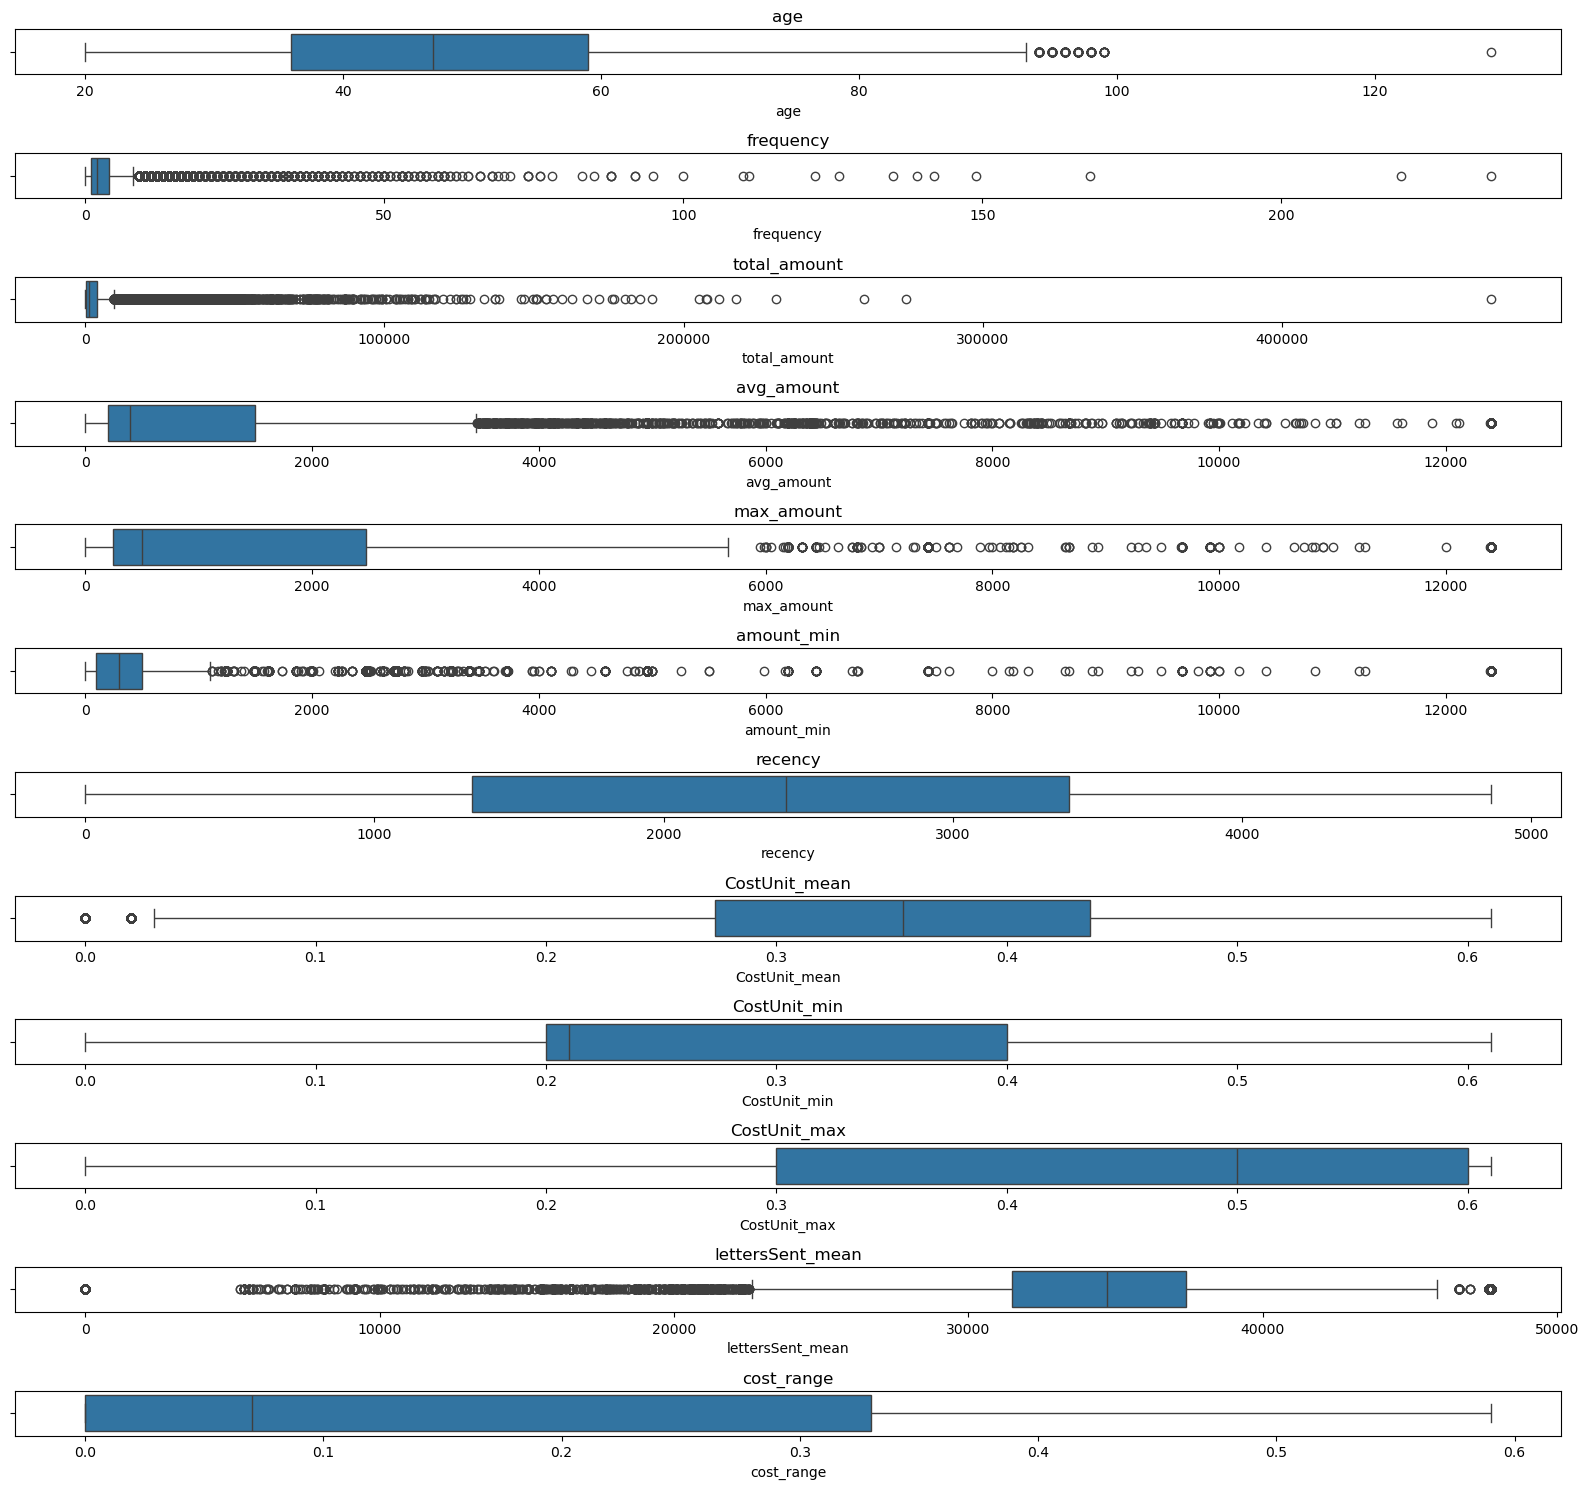

In [3625]:
# Verifying outliers
colss = ['age','frequency',
       'total_amount', 'avg_amount', 'max_amount', 'amount_min', 'recency',
       'CostUnit_mean', 'CostUnit_min', 'CostUnit_max', 'lettersSent_mean',
       'cost_range']

fig, ax = plt.subplots(nrows=len(colss), ncols=1, figsize=(16, 15))

for i, col in enumerate(colss):
    sns.boxplot(ax=ax[i], x=basetable_train[col])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [3626]:
# Winsorizing the results
lower = basetable_train[colss].quantile(0.01)
upper = basetable_train[colss].quantile(0.99)

# printing the results
print('Lower bound')
print('-' * 12)
print(lower)
print('_' * 31)
print(' ' * 25)
print('Upper bound')
print('-' * 12)
print(round(upper,2))

Lower bound
------------
age                 24.0
frequency            0.0
total_amount         0.0
avg_amount           0.0
max_amount           0.0
amount_min           0.0
recency              0.0
CostUnit_mean        0.0
CostUnit_min         0.0
CostUnit_max         0.0
lettersSent_mean     0.0
cost_range           0.0
Name: 0.01, dtype: Float64
_______________________________
                         
Upper bound
------------
age                     90.0
frequency               30.0
total_amount         50555.0
avg_amount           9333.46
max_amount           12395.0
amount_min            7437.0
recency               4626.0
CostUnit_mean            0.6
CostUnit_min             0.6
CostUnit_max            0.61
lettersSent_mean    47746.96
cost_range              0.57
Name: 0.99, dtype: Float64


In [3627]:
# Replace lower and upper values by the value of bottom 1% and top 99% (winsorization)
basetable_train = basetable_train.copy()
basetable_train[colss] = basetable_train[colss].clip(lower=lower, upper=upper, axis=1)

In [3628]:
# Verifications
print('Winsorized columns minimums:')
print('-' * 28)
print(basetable_train[colss].min())
print('_' * 30)
print(' ' * 30)
print('Winsorized columns maximums:')
print('-' * 28)
print(basetable_train[colss].max())

Winsorized columns minimums:
----------------------------
age                 24.0
frequency            0.0
total_amount         0.0
avg_amount           0.0
max_amount           0.0
amount_min           0.0
recency              0.0
CostUnit_mean        0.0
CostUnit_min         0.0
CostUnit_max         0.0
lettersSent_mean     0.0
cost_range           0.0
dtype: Float64
______________________________
                              
Winsorized columns maximums:
----------------------------
age                      90.0
frequency                30.0
total_amount          50555.0
avg_amount          9333.4625
max_amount            12395.0
amount_min             7437.0
recency                4626.0
CostUnit_mean             0.6
CostUnit_min              0.6
CostUnit_max             0.61
lettersSent_mean     47746.96
cost_range               0.57
dtype: Float64


## 2) basetable_val

### a) Cleaning columns

In [3629]:
basetable_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25645 entries, 0 to 25644
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   donorID                   25645 non-null  object         
 1   target                    25645 non-null  int64          
 2   zipcode                   25644 non-null  float64        
 3   dateOfBirth               25644 non-null  datetime64[ns] 
 4   age                       25644 non-null  Int64          
 5   age_group                 25645 non-null  int64          
 6   region_Flanders           25645 non-null  int64          
 7   region_Wallonia           25645 non-null  int64          
 8   province_Antwerp          25645 non-null  int64          
 9   province_Brussels         25645 non-null  int64          
 10  province_East Flanders    25645 non-null  int64          
 11  province_Flemish Brabant  25645 non-null  int64          
 12  prov

In [3630]:
# Dropping
basetable_val = basetable_val.drop(columns=['zipcode'])

In [3631]:
# Setting donorID to index
basetable_val = basetable_val.set_index('donorID') # Since we do not need it in the model but it still interesting to be reachable

In [3632]:
# Converting timestamps formats to a year and integer because datestamps are not accepted in the model
basetable_val['dateOfBirth'] = basetable_val['dateOfBirth'].dt.year.astype('Int64')
basetable_val['gift_date_max'] = basetable_val['gift_date_max'].dt.year.astype('Int64')
basetable_val['gift_date_min'] = basetable_val['gift_date_min'].dt.year.astype('Int64')
basetable_val['LOR'] = basetable_val['LOR'].astype(int)

In [3633]:
basetable_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25645 entries, D100001 to D144691
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   target                    25645 non-null  int64  
 1   dateOfBirth               25644 non-null  Int64  
 2   age                       25644 non-null  Int64  
 3   age_group                 25645 non-null  int64  
 4   region_Flanders           25645 non-null  int64  
 5   region_Wallonia           25645 non-null  int64  
 6   province_Antwerp          25645 non-null  int64  
 7   province_Brussels         25645 non-null  int64  
 8   province_East Flanders    25645 non-null  int64  
 9   province_Flemish Brabant  25645 non-null  int64  
 10  province_Hainaut          25645 non-null  int64  
 11  province_Liege            25645 non-null  int64  
 12  province_Limburg          25645 non-null  int64  
 13  province_Luxembourg       25645 non-null  int64  
 14  pro

### b) Missing values

In [3634]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(basetable_val.isna().sum())
print('---------------------------------')
print(f'The data shows {basetable_val.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
target                        0
dateOfBirth                   1
age                           1
age_group                     0
region_Flanders               0
region_Wallonia               0
province_Antwerp              0
province_Brussels             0
province_East Flanders        0
province_Flemish Brabant      0
province_Hainaut              0
province_Liege                0
province_Limburg              0
province_Luxembourg           0
province_Namur                0
province_Walloon Brabant      0
province_West Flanders        0
gender_M                      0
lang_FR                       0
lang_NL                       0
gift_date_max               825
gift_date_min               825
frequency                   825
total_amount                825
avg_amount                  825
max_amount                  825
amount_min                  825
recency                     825
LOR                           0
CostUnit_me

In [3635]:
# Dropping for dateOfBirth and age (likely the same donors since the same number + age computed from birthdate)
basetable_val = basetable_val.dropna(subset=['dateOfBirth', 'age'])

In [3636]:
# Inputing by 0 for the others (they likely represent the same clients as well because they are the same number and ad interconnected)
# Using the same cols list defined earlier

for col in cols:
        basetable_val[col] = basetable_val[col].fillna(value=0)

print(f'There are {basetable_val.isna().sum().sum()} missing values in the basetable at this stage.')

There are 0 missing values in the basetable at this stage.


In [3637]:
# Finding outliers (using only the numerical columns)
num_cols = basetable_val.select_dtypes(include=['float', 'int']).columns

print(num_cols)

Index(['target', 'dateOfBirth', 'age', 'age_group', 'region_Flanders',
       'region_Wallonia', 'province_Antwerp', 'province_Brussels',
       'province_East Flanders', 'province_Flemish Brabant',
       'province_Hainaut', 'province_Liege', 'province_Limburg',
       'province_Luxembourg', 'province_Namur', 'province_Walloon Brabant',
       'province_West Flanders', 'gender_M', 'lang_FR', 'lang_NL',
       'gift_date_max', 'gift_date_min', 'frequency', 'total_amount',
       'avg_amount', 'max_amount', 'amount_min', 'recency', 'LOR',
       'CostUnit_mean', 'CostUnit_min', 'CostUnit_max', 'lettersSent_mean',
       'cost_range', 'amount_per_letter', 'gifts_per_year',
       'current_value_ratio'],
      dtype='object')


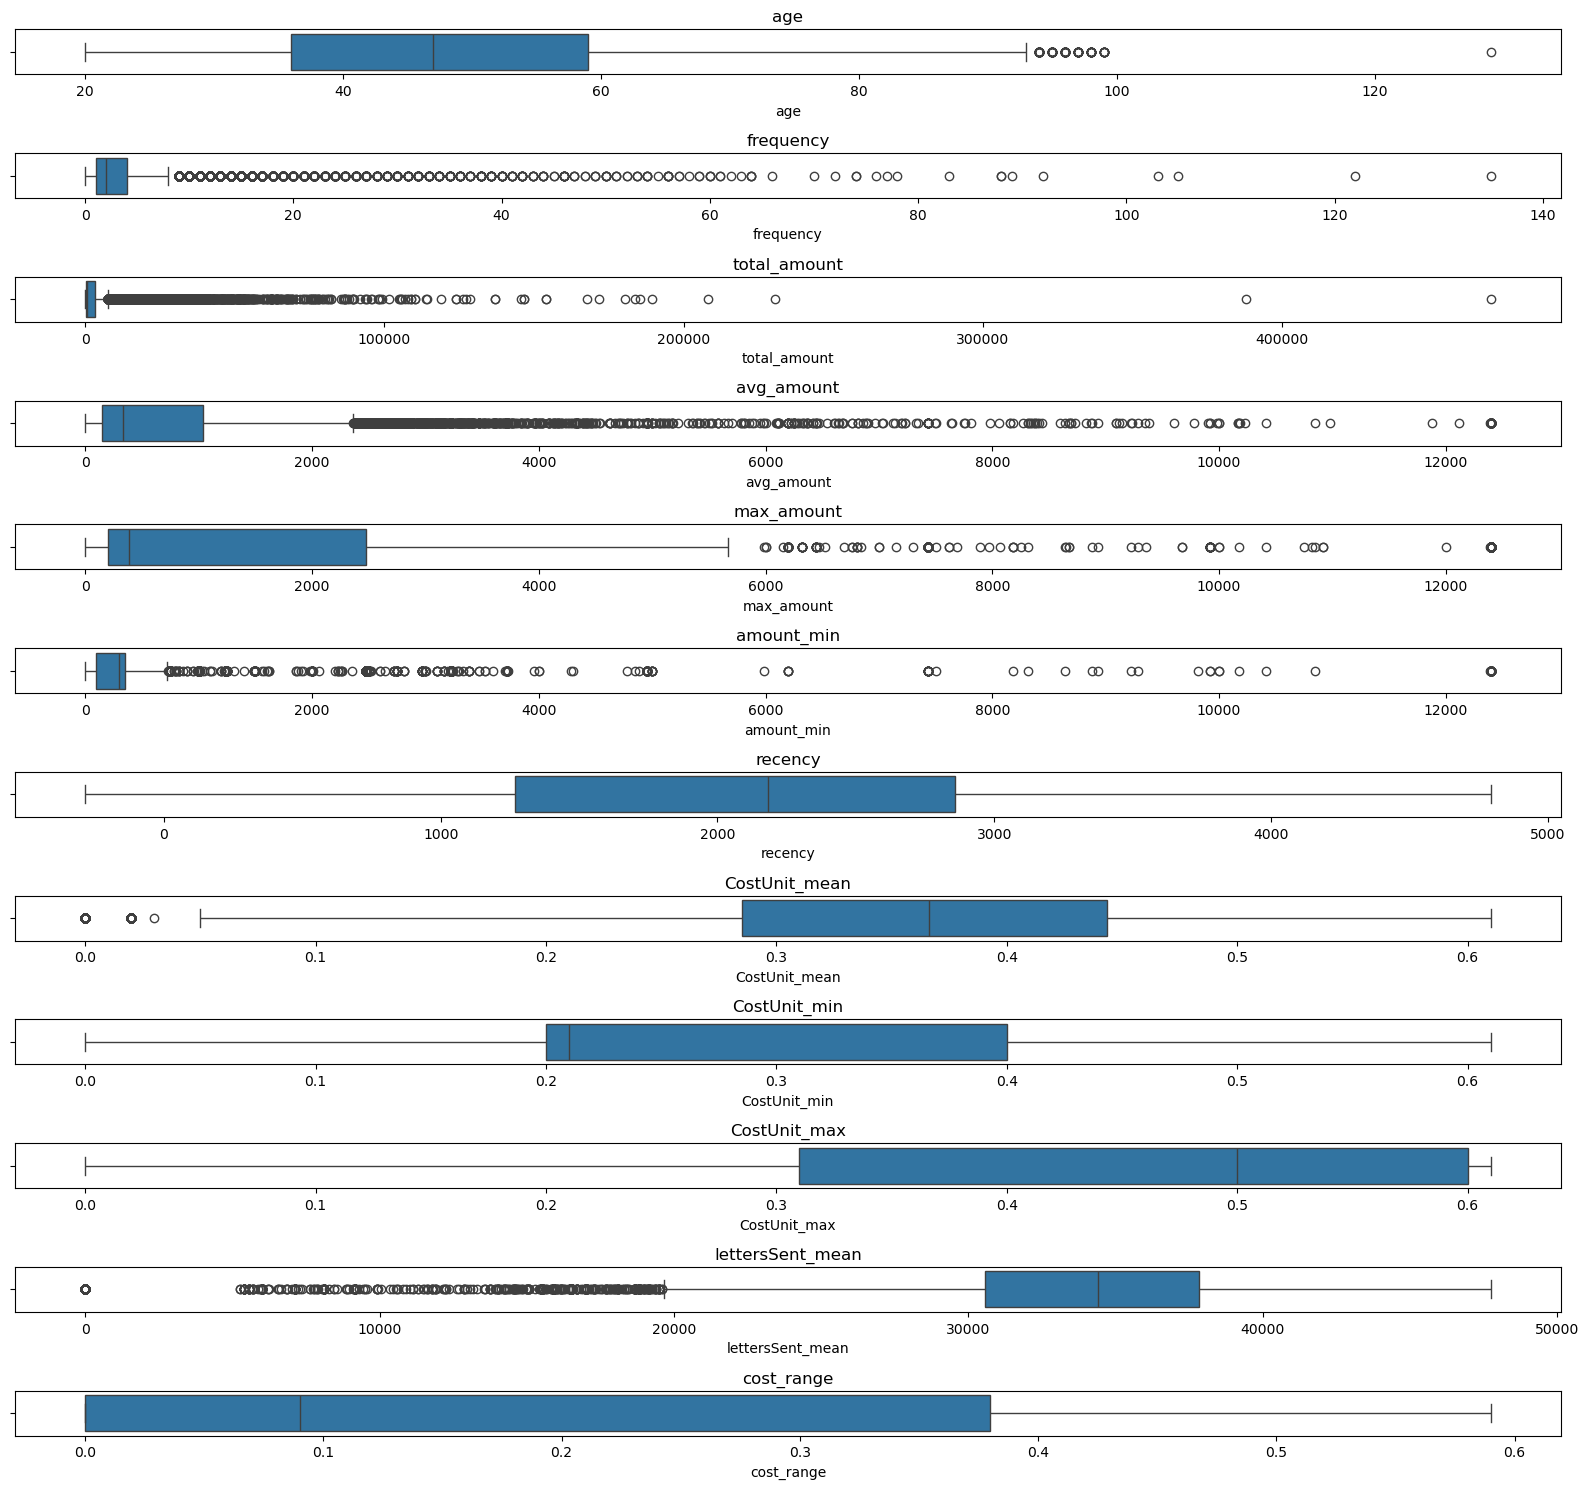

In [3638]:
# Verifying outliers
# Same columns as well

fig, ax = plt.subplots(nrows=len(colss), ncols=1, figsize=(16, 15))

for i, col in enumerate(colss):
    sns.boxplot(ax=ax[i], x=basetable_val[col])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

### c) Outliers

In [3639]:
# Winsorizing the results
lower = basetable_val[colss].quantile(0.01)
upper = basetable_val[colss].quantile(0.99)

# printing the results
print('Lower bound')
print('-' * 12)
print(lower)
print('_' * 31)
print(' ' * 25)
print('Upper bound')
print('-' * 12)
print(round(upper,2))

Lower bound
------------
age                 24.0
frequency            0.0
total_amount         0.0
avg_amount           0.0
max_amount           0.0
amount_min           0.0
recency              0.0
CostUnit_mean        0.0
CostUnit_min         0.0
CostUnit_max         0.0
lettersSent_mean     0.0
cost_range           0.0
Name: 0.01, dtype: Float64
_______________________________
                         
Upper bound
------------
age                     90.0
frequency               29.0
total_amount        43150.41
avg_amount            5061.8
max_amount           12395.0
amount_min            3225.0
recency               3765.0
CostUnit_mean            0.6
CostUnit_min             0.6
CostUnit_max            0.61
lettersSent_mean    47746.96
cost_range              0.57
Name: 0.99, dtype: Float64


In [3640]:
# Replace lower and upper values by the value of bottom 1% and top 99% (winsorization)
basetable_val = basetable_val.copy()
basetable_val[colss] = basetable_val[colss].clip(lower=lower, upper=upper, axis=1)

In [3641]:
# Verifications
print('Winsorized columns minimums:')
print('-' * 28)
print(basetable_val[colss].min())
print('_' * 30)
print(' ' * 30)
print('Winsorized columns maximums:')
print('-' * 28)
print(basetable_val[colss].max())

Winsorized columns minimums:
----------------------------
age                 24.0
frequency            0.0
total_amount         0.0
avg_amount           0.0
max_amount           0.0
amount_min           0.0
recency              0.0
CostUnit_mean        0.0
CostUnit_min         0.0
CostUnit_max         0.0
lettersSent_mean     0.0
cost_range           0.0
dtype: Float64
______________________________
                              
Winsorized columns maximums:
----------------------------
age                     90.0
frequency               29.0
total_amount        43150.41
avg_amount            5061.8
max_amount           12395.0
amount_min            3225.0
recency               3765.0
CostUnit_mean            0.6
CostUnit_min             0.6
CostUnit_max            0.61
lettersSent_mean    47746.96
cost_range              0.57
dtype: Float64


In [ ]:
# Some model testing

In [3642]:
from sklearn.model_selection import train_test_split

# 1. Define your features (X) and target (y)
# Drop non-predictive columns like ID and Date of Birth (since you have Age)
X = basetable_train.drop(columns=['target', 'dateOfBirth']) 
y = basetable_train['target']

# 2. Split 70% Train, 30% Test
# Stratify=y ensures you have the same % of donors in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (24410, 35)
Test shape: (10462, 35)


In [3643]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# 1. Train a quick Random Forest to find the best features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 2. Select features that are more important than the mean
selector = SelectFromModel(rf, threshold='mean', prefit=True)
selected_features = X_train.columns[selector.get_support()]

# 3. Update your X_train and X_test to only keep these good features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Selected {len(selected_features)} features: {list(selected_features)}")

Selected 11 features: ['age', 'total_amount', 'avg_amount', 'max_amount', 'amount_min', 'recency', 'LOR', 'lettersSent_mean', 'amount_per_letter', 'gifts_per_year', 'current_value_ratio']


In [3644]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# 1. Train
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_selected, y_train)

# 2. Predict Probabilities
# We care about the probability of donating (column 1), not just the class (0/1)
probs_test = logreg.predict_proba(X_test_selected)[:, 1]

# 3. Check initial performance (AUC)
auc = roc_auc_score(y_test, probs_test)
print(f"Baseline AUC Score: {auc:.4f}")

Baseline AUC Score: 0.5620


In [3645]:
from sklearn.ensemble import RandomForestClassifier

# 1. Initialize Random Forest with more trees
# class_weight='balanced' helps with the imbalance (few donors vs many non-donors)
rf_model = RandomForestClassifier(n_estimators=300, max_depth=10, class_weight='balanced', random_state=42)

# 2. Train the model
rf_model.fit(X_train_selected, y_train)

# 3. Predict probabilities
rf_probs = rf_model.predict_proba(X_test_selected)[:, 1]

# 4. Evaluate
rf_auc = roc_auc_score(y_test, rf_probs)
print(f"Random Forest AUC: {rf_auc:.4f}")

Random Forest AUC: 0.9755


In [3646]:
from sklearn.model_selection import RandomizedSearchCV

# 1. Define the parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 5, 10]
}

# 2. Setup Random Search (tries random combinations)
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_distributions=param_grid,
    n_iter=10,  # Try 10 combinations
    cv=3,       # 3-fold cross-validation
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

# 3. Fit to data
random_search.fit(X_train_selected, y_train)

# 4. Best Model
best_model = random_search.best_estimator_
print(f"Best Params: {random_search.best_params_}")
print(f"Best Cross-Val AUC: {random_search.best_score_:.4f}")

Best Params: {'n_estimators': 300, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 20}
Best Cross-Val AUC: 0.9785


In [3647]:
# Check if any gifts assigned to the target campaign (6169) are in your history features
leakage_check = gifts[
    (gifts['campaignID'] == 6169) & 
    (gifts['gift_date'] < rd1)  # These should NOT exist
]

print(f"Number of leaking gifts: {len(leakage_check)}")

if len(leakage_check) > 0:
    print("WARNING: DATA LEAKAGE DETECTED.")
    print("The target gifts are included in your input features.")
    print("Fix: Set 'rd1' to a date BEFORE the very first gift of campaign 6169.")
else:
    print("No obvious timestamp leakage detected. The model might just be very good!")

Number of leaking gifts: 0
No obvious timestamp leakage detected. The model might just be very good!
